# Homework 1: Sentence Transformers for Sentiment Classification 🎬🤖

## High-Level Overview

In this homework, you will explore how **pretrained language models** can be adapted for a downstream NLP task: **sentiment classification on the IMDB movie reviews dataset**.  
The exercise is designed to gradually introduce you to the key concepts of **transfer learning**, **fine-tuning**, and **evaluation** in modern NLP.

Here’s the journey you’ll go through:

1. **Establish a Baseline 🏁**  
   Start with a frozen encoder (e.g., `all-MiniLM-L6-v2`) and attach a simple classifier head. This acts as a linear probe to measure the quality of pretrained representations.

2. **Fine-Tune the Model 🔧**  
   Unfreeze the transformer and train end-to-end on IMDB sentiment data. This shows how task-specific supervision can adapt pretrained embeddings.

3. **Evaluate & Compare 📊**  
   Use accuracy, precision, recall, and confusion matrices to quantify the improvements from fine-tuning over the baseline.

4. **Build Good Practices 📝**  
   Implement reproducibility helpers, logging, and simple visualizations (loss curves, confusion matrix). These are essential habits in real research.

By the end of this homework, you should understand:
- The difference between frozen vs. fine-tuned representations.
- How to set up training and evaluation loops for sentence transformers.
- How to critically assess model performance beyond just accuracy.

👉 This is not just about “running code”—it’s about **thinking like a researcher**: setting baselines, asking *why* fine-tuning helps, and interpreting what the metrics tell us about model behavior.


## Evaluation and Grading

You will be graded through some visible test cases that are in the notebook in form of assert statements and one or more hidden test cases, that only TAs have access to. Throughout the notebook, there are TODOs left for the students to fill in with their own code. Make sure you fill those sections in before moving ahead

## 🔧 Setup & Utilities

Before we dive into modeling, let’s set up a few helper functions and utilities:

- **Seed Setting** → ensures reproducibility across runs.  
- **Metric Dictionary** → computes accuracy, precision, recall, and F1 (both micro and macro).  
- **Confusion Matrix Plotter** → visualizes where the model is doing well vs. struggling.  
- **CUDA Environment** → ensures GPU usage if available.

**Throughout this notebook, there are "TODO"s left for students to fill in, make sure you write your own code in those sections before moving ahead"

In [1]:
# pip install -U sentence-transformers


In [2]:
# import sys
# !{sys.executable} -m pip install -U "torch>=2.2"


In [3]:
import random, os, json
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

def set_seeds(seed: int = 42):
    import torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def metric_dict(y_true, y_pred):
    # TODO: compute accuracy  
    # TODO: compute precision/recall/f1 (micro)
    # TODO: compute precision/recall/f1 (macro)
    
    # accuracy 
    acc = accuracy_score(y_true, y_pred)
    
    # micro
    prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro", zero_division=0
    )
    
    # macro
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    
    return {
        "accuracy": acc,
        "precision_micro": prec_micro,
        "recall_micro": rec_micro,
        "f1_micro": f1_micro,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
    }

def plot_confusion_matrix(cm, labels=("neg","pos"), title="Confusion Matrix"):
    fig = plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     horizontalalignment="center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

# enforce deterministic runs on GPU 0
set_seeds(42)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2025-09-22 01:38:30.287595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758505110.469066      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758505110.520497      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
## Test Cases
# ✅ Tests
y_true = [0, 1, 0, 1]
y_pred = [0, 1, 1, 0]

m = metric_dict(y_true, y_pred)
assert 0 <= m["accuracy"] <= 1, "accuracy should be between 0 and 1"

# confusion matrix smoke test
cm = confusion_matrix(y_true, y_pred)
assert cm.shape == (2, 2)

print("Setup tests passed!")

# 🔍 Extra test: perfect prediction should give acc=1.0
perfect_pred = metric_dict(y_true, y_true)
assert abs(perfect_pred["accuracy"] - 1.0) < 1e-8

# 🔍 Extra test: all wrong prediction should give acc=0.0
wrong_pred = metric_dict(y_true, [1 - y for y in y_true])
assert abs(wrong_pred["accuracy"] - 0.0) < 1e-8

print("Extra metric_dict tests passed!")


Setup tests passed!
Extra metric_dict tests passed!


## 📂 Load & Explore the IMDB Dataset

We’ll use the **Stanford IMDB movie reviews dataset**, a classic benchmark for sentiment classification (positive vs. negative).  
In this step, we:

- Load the dataset from 🤗 `datasets`.  
- Split into **train** and **test** sets.  
- Inspect the dataset sizes and label distribution to get a sense of the task.


In [5]:
# import sys
# # update fsspec
# !{sys.executable} -m pip install -U "fsspec>=2023.10.0"
# # update huggingface
# !{sys.executable} -m pip install -U datasets huggingface_hub pyarrow xxhash


In [6]:
# TODO
from datasets import load_dataset

ds = load_dataset("stanfordnlp/imdb")

# TODO
train_ds = ds["train"]
test_ds  = ds["test"]

# TODO
train_texts = list(train_ds["text"])
train_labels = list(train_ds["label"])
test_texts  = list(test_ds["text"])
test_labels = list(test_ds["label"])

print(f"Train size: {len(train_texts)}  |  Test size: {len(test_texts)}")
print(f"Label set (train): {set(train_labels)}")

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train size: 25000  |  Test size: 25000
Label set (train): {0, 1}


In [7]:
# ✅ Tests
assert isinstance(train_texts, list), "train_texts should be a list"
assert len(train_texts) == len(train_labels), "train_texts and train_labels must align"
assert len(test_texts) == len(test_labels), "test_texts and test_labels must align"
assert set(train_labels).issubset({0,1}), "train labels must be 0/1"
assert set(test_labels).issubset({0,1}), "test labels must be 0/1"

print("Data preparation tests passed!")

# 🔍 Extra tests
assert len(train_texts) > 20000, "IMDB train set should have ~25k samples"
assert len(test_texts) > 20000, "IMDB test set should have ~25k samples"
print("Extra dataset size tests passed!")


Data preparation tests passed!
Extra dataset size tests passed!


In [8]:
# TODO: count how many 0s and 1s are in train_labels
num_train_zeros = train_labels.count(0)
num_train_ones  = train_labels.count(1)

# TODO: count how many 0s and 1s are in test_labels
num_test_zeros  = test_labels.count(0)
num_test_ones   = test_labels.count(1)

print(f"training:\n\t# of 0s: {num_train_zeros}\n\t# of 1s: {num_train_ones}\n"
      f"\ntesting:\n\t# of 0s: {num_test_zeros}\n\t# of 1s: {num_test_ones}")


training:
	# of 0s: 12500
	# of 1s: 12500

testing:
	# of 0s: 12500
	# of 1s: 12500


In [9]:
# ✅ Tests
assert num_train_zeros == 12500, "Expected exactly 12500 zeros in train set"
assert num_train_ones == 12500, "Expected exactly 12500 ones in train set"
assert num_test_zeros == 12500, "Expected exactly 12500 zeros in test set"
assert num_test_ones == 12500, "Expected exactly 12500 ones in test set"
print("Label distribution tests passed!")

# 🔍 Extra tests
assert (num_train_zeros + num_train_ones) == len(train_labels), "Mismatch in train label counts"
assert (num_test_zeros + num_test_ones) == len(test_labels), "Mismatch in test label counts"
print("Extra label consistency tests passed!")


Label distribution tests passed!
Extra label consistency tests passed!


## 🔎 Encode Texts into Embeddings

Next, we transform the raw movie reviews into **dense vector embeddings** using a pretrained SentenceTransformer (`all-MiniLM-L6-v2`).  
These embeddings capture the **semantic meaning** of the text and will serve as features for our downstream classifiers.  

We also run a few quick sanity checks ✅ to make sure the embeddings look as expected:
- Number of rows = number of training/testing examples  
- Dimensionality is consistent across train/test sets


In [ ]:
# hugging face
!hf auth login

In [10]:
BASE_MODEL = "all-MiniLM-L6-v2"
encoder = SentenceTransformer(BASE_MODEL)

X_train = encoder.encode(train_texts, batch_size=64, convert_to_numpy=True, show_progress_bar=True)
X_test  = encoder.encode(test_texts, batch_size=64, convert_to_numpy=True, show_progress_bar=True)

print("Embeddings:", X_train.shape, X_test.shape)

# ✅ Tests
assert X_train.shape[0] == len(train_texts)
assert X_test.shape[0] == len(test_texts)
assert X_train.shape[1] == X_test.shape[1]
print("Embedding tests passed!")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Embeddings: (25000, 384) (25000, 384)
Embedding tests passed!


## 🏁 Baseline Classifier Training & Evaluation

With our embeddings ready, let’s train a **Logistic Regression classifier** as a simple baseline:  

- **Training** → Fit the classifier on the training embeddings.  
- **Evaluation** → Predict on the test set and compute accuracy, precision, recall, and F1 scores.  
- **Confusion Matrix** → Visualize how well the baseline separates positive vs. negative reviews.  

We also include a few quick tests ✅ to confirm:
- Predictions match the test set size.  
- Metrics are returned correctly.  
- Accuracy is reasonable (> 0.75).  
- Confusion matrix is valid (2×2 for binary classification).  


=== Baseline Metrics ===
{
  "accuracy": 0.81124,
  "precision_micro": 0.81124,
  "recall_micro": 0.81124,
  "f1_micro": 0.81124,
  "precision_macro": 0.8112619626440841,
  "recall_macro": 0.81124,
  "f1_macro": 0.8112366702148626
}


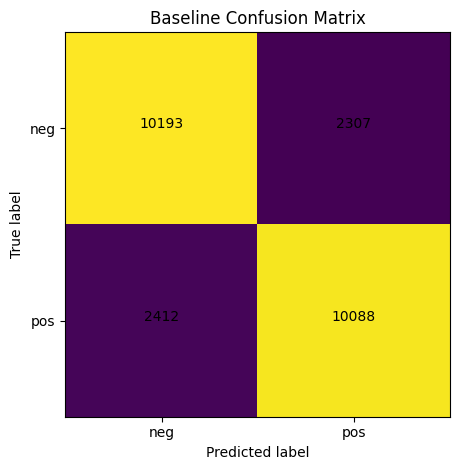

In [11]:
# === Classifier Training ===
# TODO: initialize a LogisticRegression classifier (use the already imported sklearn.linear_model.LogisticRegression)
clf = LogisticRegression(max_iter=1000)

# TODO: fit classifier on training embeddings
clf.fit(X_train, train_labels)

# === Baseline Evaluation ===
# TODO: predict labels for the test set
pred_baseline = clf.predict(X_test)

# TODO: compute metrics
metrics_baseline = metric_dict(test_labels, pred_baseline)

# TODO: compute confusion matrix
cm_baseline = confusion_matrix(test_labels, pred_baseline)

print("=== Baseline Metrics ===")
print(json.dumps(metrics_baseline, indent=2))

# TODO: plot confusion matrix
plot_confusion_matrix(cm_baseline, labels=("neg","pos"), title="Baseline Confusion Matrix")


In [12]:
# ✅ Tests
assert len(pred_baseline) == len(test_labels), "Number of predictions must match test set size"
assert isinstance(metrics_baseline, dict), "metrics_baseline should be a dictionary"
assert 0 <= metrics_baseline["accuracy"] <= 1, "Accuracy must be between 0 and 1"
print("Baseline evaluation tests passed!")

# 🔍 Extra tests
assert cm_baseline.shape == (2, 2), "Confusion matrix must be 2x2 for binary classification"
assert all(label in [0, 1] for label in np.unique(pred_baseline)), "Predictions must be 0/1"
print("Extra baseline tests passed!")


Baseline evaluation tests passed!
Extra baseline tests passed!


## 🔄 Part B0 — Imports & Tiny Helpers

Before diving into **fine-tuning**, we’ll set up a few essentials:  

- **Core Libraries** → HuggingFace `datasets`, SentenceTransformers, and PyTorch DataLoader.  
- **Evaluation Tools** → Accuracy, precision, recall, F1, and confusion matrices from scikit-learn.  
- **Seed Setting** → Ensures reproducibility across runs.  

We also do a quick **sanity check** ✅ with a dummy `InputExample` to confirm everything is wired up correctly.


In [13]:
# B0 — Imports & tiny helpers (reuse if running standalone)
import random, json, os
import numpy as np

from datasets import load_dataset
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

def set_seeds(seed: int = 42):
    import torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seeds(42)

# ✅ Tests
dummy = InputExample(texts=["hello","hello"], label=1)
assert isinstance(dummy, InputExample)
print("Helper imports & InputExample test passed!")


Helper imports & InputExample test passed!


## 📂 Load & Split the IMDB Dataset

Now we prepare the IMDB dataset for **fine-tuning**:  

- Load the full training set and test set.  
- Create a **90/10 split** of the training set into **train** and **validation**.  
  - Train → used for updating model weights.  
  - Validation → used to tune hyperparameters and check for overfitting.  
- Keep the official test set aside for the final evaluation.  

A few quick tests ✅ ensure the split sizes make sense.


In [14]:
# Load IMDB
ds = load_dataset("stanfordnlp/imdb")
train_full = ds["train"]
test_ds    = ds["test"]

# 90/10 split for val
idx = list(range(len(train_full)))
random.shuffle(idx)
cut = int(0.9 * len(idx))
train_idx, val_idx = idx[:cut], idx[cut:]

train_ds = train_full.select(train_idx)
val_ds   = train_full.select(val_idx)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

# ✅ Tests
assert len(train_ds) + len(val_ds) == len(train_full)
assert len(train_ds) > len(val_ds)
assert len(test_ds) > 0
print("Dataset split tests passed!")

Train: 22500 | Val: 2500 | Test: 25000
Dataset split tests passed!


In [15]:
# Count labels
num_train_zeros = sum(1 for l in train_ds["label"] if l == 0)
num_train_ones  = sum(1 for l in train_ds["label"] if l == 1)
num_val_zeros   = sum(1 for l in val_ds["label"] if l == 0)
num_val_ones    = sum(1 for l in val_ds["label"] if l == 1)
num_test_zeros  = sum(1 for l in test_ds["label"] if l == 0)
num_test_ones   = sum(1 for l in test_ds["label"] if l == 1)

print(f"training:\n\t# of 0s: {num_train_zeros}\n\t# of 1s: {num_train_ones}\n"
      f"\nvalidation:\n\t# of 0s: {num_val_zeros}\n\t# of 1s: {num_val_ones}\n"
      f"\ntesting:\n\t# of 0s: {num_test_zeros}\n\t# of 1s: {num_test_ones}")

# ✅ Tests
assert num_test_ones == num_test_zeros
assert abs(num_train_ones - num_train_zeros) < 100
assert abs(num_val_ones - num_val_zeros) < 100
print("Class balance tests passed!")


training:
	# of 0s: 11267
	# of 1s: 11233

validation:
	# of 0s: 1233
	# of 1s: 1267

testing:
	# of 0s: 12500
	# of 1s: 12500
Class balance tests passed!


## ⚙️ Tokenization, Dataset, and Model Setup

Time to get our data ready for **transformer fine-tuning**:  

- **Tokenizer** → Converts raw text into token IDs with truncation and dynamic padding.  
- **Custom Dataset Class** → Wraps the IMDB reviews so they can be fed to PyTorch DataLoaders.  
- **DataLoader** → Handles batching with dynamic padding for efficiency.  
- **Model Initialization** → Load a pretrained transformer (`all-MiniLM-L6-v2`) for sequence classification with a built-in cross-entropy head.  

We also add a few **precondition checks** ✅ to ensure the dataset columns are correct and labels are valid (0/1).


In [16]:
import os, math, torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
)

# (optional) force GPU 0 only
os.environ.setdefault("CUDA_VISIBLE_DEVICES", "0")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO: pick a base encoder
BASE_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

# TODO: load tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

# ✅ Preconditions
assert "text" in train_ds.column_names and "label" in train_ds.column_names, "train_ds must have 'text' and 'label'"
assert len(train_ds) > 0, "Empty train_ds"
assert set(train_ds["label"]).issubset({0, 1}), "Labels must be 0/1"

# Torch dataset
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.maxlen = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        enc = self.tok(
            self.texts[i],
            truncation=True,
            max_length=self.maxlen,
            padding=False  # padding handled by collator
        )
        enc["labels"] = int(self.labels[i])
        return enc

train_dataset = IMDBDataset(train_ds["text"], train_ds["label"], tokenizer)

# DataLoader (dynamic padding + tensors)
BATCH_SIZE = 32
collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=collator
)

# TODO: load classification model with num_labels=2
num_labels=2
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=num_labels).to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 🚀 Fine-Tuning the Transformer

Now we fine-tune the pretrained transformer on the IMDB dataset:  

- **Optimizer** → Use AdamW with a small learning rate (`2e-5`), a common choice for transformers.  
- **Training Loop** → For each epoch, batch the data, run forward + backward passes, and update model weights.  
- **Progress Bar** → `tqdm` shows real-time loss values as training progresses.  
- **Loss Tracking** → Store losses at each step to visualize training dynamics.  

Finally, we plot 📉 the training loss curve to confirm the model is learning.


Epoch 5/5: 100%|██████████| 704/704 [02:10<00:00,  5.39it/s, loss=0.0039]


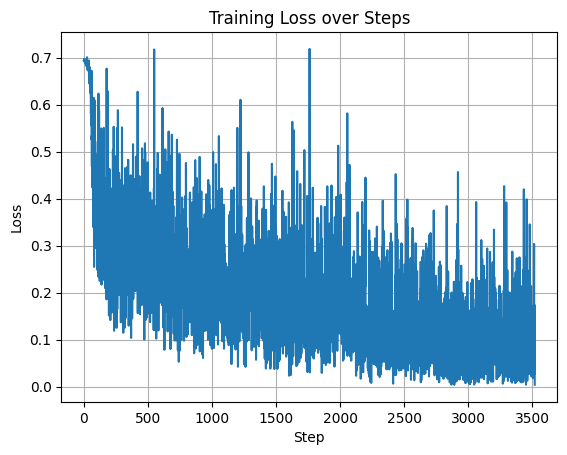

In [17]:
from tqdm import tqdm
import matplotlib.pyplot as plt

LR = 2e-5
EPOCHS = 5

# TODO: initialize AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

loss_values = []

# TODO: set model to train mode
model.train()

for epoch in range(EPOCHS):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in pbar:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        # TODO: zero gradients
        optimizer.zero_grad(set_to_none=True)

        # TODO: forward pass
        out = model(**batch)

        # TODO: compute loss
        loss = out.loss

        # TODO: backward + optimizer step
        loss.backward()
        # (optional) 
        optimizer.step()

        loss_values.append(loss.item())
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

# 📉 Plot training loss
plt.plot(loss_values)
plt.title("Training Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [18]:
# 🔍 Extra tests
import numpy as np
mean_loss = np.mean(loss_values)
assert mean_loss < 0.4, "Mean loss should be less than 0.4"
print("Extra training loop tests passed!")


Extra training loop tests passed!


## 📊 Evaluate the Fine-Tuned Model

After training, we test our model on the **held-out IMDB test set**:  

- **Dataset & DataLoader** → Wrap the test split for batching and tokenization.  
- **Evaluation Mode** → Disable gradient updates (`model.eval()` + `torch.no_grad()`) for efficiency.  
- **Prediction** → Collect the model’s predicted labels vs. true labels.  
- **Metric** → Report **accuracy** as a first measure of performance.  

This gives us a sense of how well fine-tuning improved over the baseline 🚀.


In [19]:
# Build test dataset & dataloader
test_dataset = IMDBDataset(test_ds["text"], test_ds["label"], tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    collate_fn=collator
)

# Run predictions
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        labels = batch.pop("labels")

        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")


Evaluating: 100%|██████████| 782/782 [00:54<00:00, 14.40it/s]

Test Accuracy: 0.9062


In [20]:
assert acc > 0.9, "Note that this is higher than the baseline accuracy"

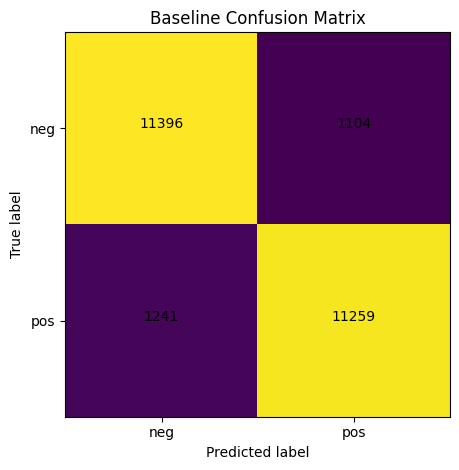

In [21]:
cm_new = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm_new, labels=("neg","pos"), title="Baseline Confusion Matrix")

## compare with cm_baseline and convince yourself that this is a better confusion matrix